### Train

In [2]:
import json
import matplotlib.pyplot as plt

# Load training log JSON file
training_log_path = "/raid/decaro/TimeSeriesForecastingFoundationModels/chronos_output/chronos-bolt-base/run-0/training_log.json"
with open(training_log_path, "r") as f:
    training_logs = json.load(f)

In [3]:
summary = training_logs[-2]
training_logs = training_logs[:-2]

In [4]:
# Pretty-print training summary
print("=== Final Training Summary ===")
print(f"Total training time:           {summary['train_runtime']:.2f} seconds")
print(f"Samples per second:            {summary['train_samples_per_second']:.2f}")
print(f"Steps per second:              {summary['train_steps_per_second']:.3f}")
print(f"Total FLOPs:                   {summary['total_flos']:.2e}")
print(f"Final training loss:           {summary['train_loss']:.4f}")

# Find best model (based on minimum loss)
best_entry = min(training_logs, key=lambda x: x["loss"])
best_epoch = best_entry["epoch"]
best_loss = best_entry["loss"]

print("=== Best Model During Training ===")
print(f"Epoch:                         {best_epoch}")
print(f"Step:                          {int(best_epoch*200_000)}")
print(f"Loss:                          {best_loss:.4f}")

=== Final Training Summary ===
Total training time:           128358.67 seconds
Samples per second:            99.72
Steps per second:              1.558
Total FLOPs:                   7.81e+18
Final training loss:           2.4942
=== Best Model During Training ===
Epoch:                         0.9775
Step:                          195500
Loss:                          2.1913


In [5]:
# Extract metrics from the log
epochs = [entry["epoch"] for entry in training_logs]
steps = [entry["epoch"]*200_000 for entry in training_logs]
losses = [entry["loss"] for entry in training_logs]
grad_norms = [entry["grad_norm"] for entry in training_logs]
learning_rates = [entry["learning_rate"] for entry in training_logs]

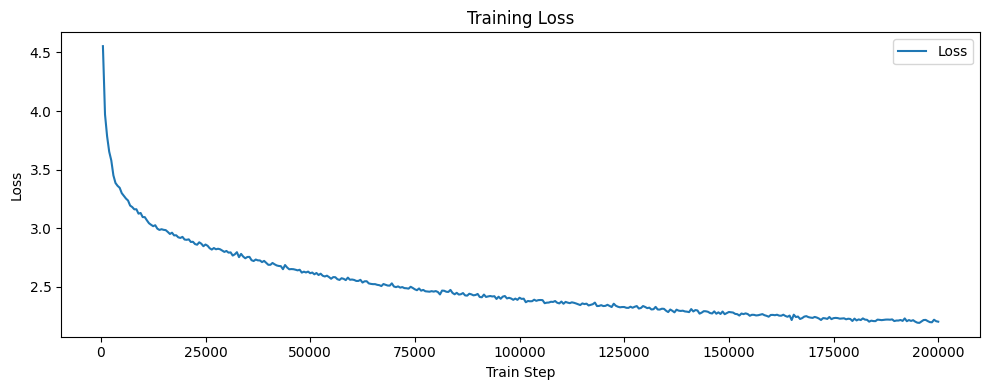

In [6]:
# Plot: Loss vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, losses, label="Loss", color="tab:blue")
plt.xlabel("Train Step")
plt.ylabel("Loss")
plt.title("Training Loss")
#plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"figures/learning_curve_chronos_bolt_base.pdf")
plt.show()

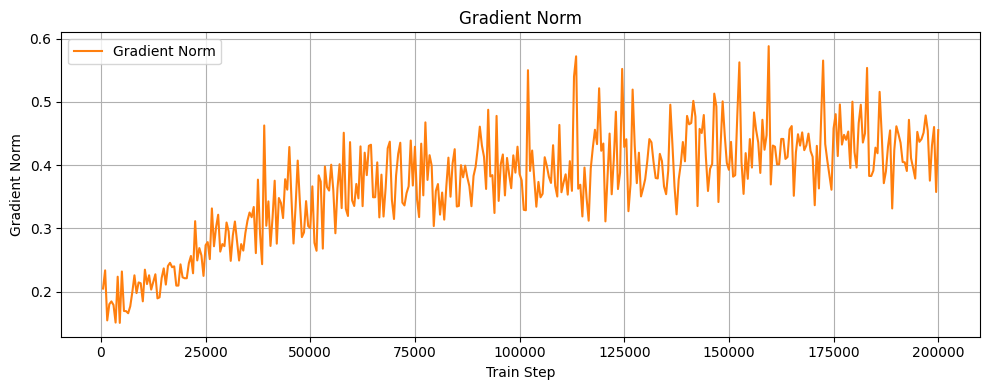

In [7]:
# Plot: Gradient Norm vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, grad_norms, label="Gradient Norm", color="tab:orange")
plt.xlabel("Train Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

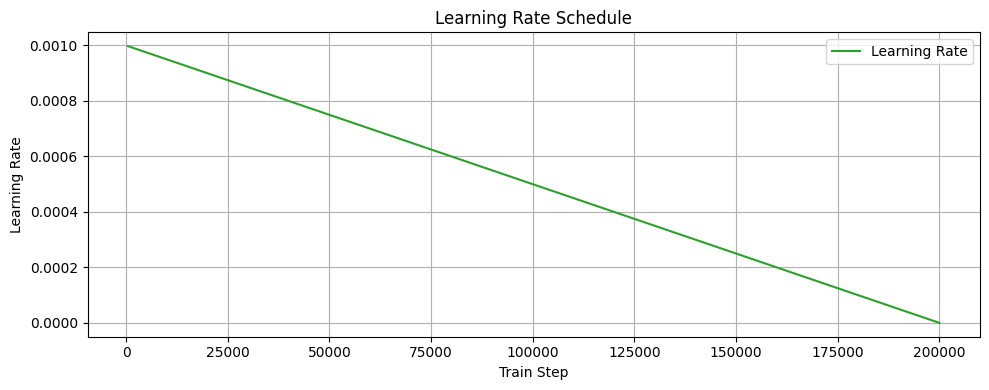

In [8]:
# Plot: Learning Rate vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, learning_rates, label="Learning Rate", color="tab:green")
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Test

In [9]:
import pandas as pd

result_path = "results/test/chronos_bolt_base_test_results.csv"

In [10]:
df = pd.read_csv(result_path)
df = df[["dataset", "domain", "num_variates", "model", "train_step",
    "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
df = df.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
df = df.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})
df = df.rename(columns={"train_step": "train step"})

In [11]:
df.head()

,dataset,domain,num_variates,model,train step,MASE,Qloss
0,exchange_rate/short,Econ/Fin,1,chronos-bolt-base,500,24.251517,0.063937
1,exchange_rate/medium,Econ/Fin,1,chronos-bolt-base,500,20.395774,0.061711
2,exchange_rate/long,Econ/Fin,1,chronos-bolt-base,500,19.877615,0.059450
3,ercot/short,Energy,1,chronos-bolt-base,500,2.493600,0.161155
4,ercot/medium,Energy,1,chronos-bolt-base,500,2.703264,0.169326


In [12]:
def parse_dataset_string(s):
    parts = s.split('/')
    if len(parts) == 2:
        dataset = parts[0]
        freq = None
        term = parts[1]
    elif len(parts) == 3:
        dataset, freq, term = parts
    else:
        raise ValueError(f"Unexpected dataset format: {s}")
    return pd.Series([dataset, freq, term])

# Apply the parsing
df[['dataset_name', 'freq', 'term']] = df['dataset'].apply(parse_dataset_string)

# Manually fill missing frequencies
freq_map = {
    'exchange_rate': 'D',
    'ercot': 'H',
    'dominick': 'W'
}

df['freq'] = df.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
df.drop(columns='dataset', inplace=True)

df = df.rename(columns={"dataset_name": "dataset"})
df = df[["dataset", "freq", "term", "domain", "num_variates", "model", "train step",
    "MASE", "Qloss"]]


In [13]:
df.head()

,dataset,freq,term,domain,num_variates,model,train step,MASE,Qloss
0,exchange_rate,D,short,Econ/Fin,1,chronos-bolt-base,500,24.251517,0.063937
1,exchange_rate,D,medium,Econ/Fin,1,chronos-bolt-base,500,20.395774,0.061711
2,exchange_rate,D,long,Econ/Fin,1,chronos-bolt-base,500,19.877615,0.059450
3,ercot,H,short,Energy,1,chronos-bolt-base,500,2.493600,0.161155
4,ercot,H,medium,Energy,1,chronos-bolt-base,500,2.703264,0.169326


In [14]:
grouped_domain = df.groupby(['train step', 'domain'], as_index=False).mean(numeric_only=True)
grouped_domain = grouped_domain.sort_values(by=['train step', 'domain'])
grouped_domain

,train step,domain,num_variates,MASE,Qloss
0,500,Econ/Fin,1.0,21.508302,0.061699
1,500,Energy,1.0,2.560226,0.891991
2,500,Nature,21.0,1.110021,0.128783
3,500,Sales,1.0,2.941774,1.114411
4,500,Web/CloudOps,3.5,3.979815,0.659384
...,...,...,...,...,...
100,200000,Econ/Fin,1.0,19.390226,0.059601
101,200000,Energy,1.0,2.573228,0.892387
102,200000,Nature,21.0,1.154478,0.129399
103,200000,Sales,1.0,3.059439,1.096758


In [15]:
grouped_freq = df.groupby(['train step', 'freq'], as_index=False).mean(numeric_only=True)
grouped_freq = grouped_freq.sort_values(by=['train step', 'freq'])
grouped_freq

,train step,freq,num_variates,MASE,Qloss
0,500,10S,2.000000,7.889286,0.117009
1,500,10T,11.000000,1.761450,0.783277
2,500,5T,3.666667,2.157072,0.844570
3,500,D,5.000000,13.563211,0.167289
4,500,H,6.714286,2.349777,0.704702
...,...,...,...,...,...
121,200000,10T,11.000000,1.764721,0.783585
122,200000,5T,3.666667,2.164318,0.845388
123,200000,D,5.000000,12.348742,0.166259
124,200000,H,6.714286,2.353726,0.701117


In [16]:
grouped_term = df.groupby(['train step', 'term'], as_index=False).mean(numeric_only=True)
grouped_term = grouped_term.sort_values(by=['train step', 'term'])
grouped_term

,train step,term,num_variates,MASE,Qloss
0,500,long,5.307692,4.454685,0.632087
1,500,medium,5.307692,4.524846,0.614376
2,500,short,5.333333,4.008070,0.623632
3,10000,long,5.307692,4.429793,0.624846
4,10000,medium,5.307692,4.518108,0.620652
...,...,...,...,...,...
58,190000,medium,5.307692,4.479677,0.611839
59,190000,short,5.333333,3.842254,0.634698
60,200000,long,5.307692,4.401729,0.619709
61,200000,medium,5.307692,4.513422,0.616086


In [17]:
MODEL = "chronos_bolt_base"
baseline_results = pd.read_csv(f"results/baseline_test/{MODEL}_results.csv")


chronos_benchmark = pd.read_csv("results/baseline_test/chronos_benchmark_results.csv")
chronos_benchmark = chronos_benchmark[chronos_benchmark["model"] == MODEL]

baseline_results = pd.concat([baseline_results, chronos_benchmark])

In [18]:
baseline_results = baseline_results[["dataset", "domain", "num_variates", "model",
    "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
baseline_results = baseline_results.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
baseline_results = baseline_results.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})

baseline_results[['dataset_name', 'freq', 'term']] = baseline_results['dataset'].apply(parse_dataset_string)

baseline_results['freq'] = baseline_results.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
baseline_results.drop(columns='dataset', inplace=True)

baseline_results = baseline_results.rename(columns={"dataset_name": "dataset"})
baseline_results = baseline_results[["dataset", "freq", "term", "domain", "num_variates", "model",
    "MASE", "Qloss"]]

In [19]:
baseline_results.head()

,dataset,freq,term,domain,num_variates,model,MASE,Qloss
0,bizitobs_application,10S,short,Web/CloudOps,2,chronos_bolt_base,5.533290,0.053958
1,bizitobs_application,10S,medium,Web/CloudOps,2,chronos_bolt_base,9.720338,0.103502
2,bizitobs_application,10S,long,Web/CloudOps,2,chronos_bolt_base,10.483795,0.108976
3,bizitobs_l2c,5T,short,Web/CloudOps,7,chronos_bolt_base,0.278185,0.074353
4,bizitobs_l2c,5T,medium,Web/CloudOps,7,chronos_bolt_base,0.877710,0.445441


In [20]:
baseline_term = baseline_results.groupby(['term'], as_index=False).mean(numeric_only=True)
baseline_domain = baseline_results.groupby(['domain'], as_index=False).mean(numeric_only=True)
baseline_freq = baseline_results.groupby(['freq'], as_index=False).mean(numeric_only=True)

In [21]:
import matplotlib.pyplot as plt

def plot_metric_vs_train_step(grouped, baseline, group_col, metric_cols, title_prefix):
    """
    For each unique value in group_col (e.g. 'term', 'domain', 'freq'), plot the metric vs train step.
    
    Parameters:
        grouped: DataFrame with columns ['train step', group_col, ...metric_cols]
        baseline: DataFrame with columns [group_col, ...metric_cols]
        group_col: str, name of group column
        metric_cols: list of str, metric names (e.g. ['MASE', 'Qloss'])
        title_prefix: str, to prefix plot titles
    """
    unique_groups = sorted(grouped[group_col].unique())
    
    for metric in metric_cols:
        for group_value in unique_groups:
            # Filter Chronos results for this group value
            df_sub = grouped[grouped[group_col] == group_value]

            if df_sub.empty:
                continue  # Skip empty group
            
            # Get baseline value for this group (if available)
            baseline_value = baseline.loc[baseline[group_col] == group_value, metric]
            baseline_y = baseline_value.iloc[0] if not baseline_value.empty else None

            # Plot
            plt.figure(figsize=(6, 3))
            plt.plot(df_sub["train step"], df_sub[metric], marker='o', label="Finetuned")
            
            if baseline_y is not None:
                plt.axhline(y=baseline_y, color="black", linestyle="--", label="Baseline")

            plt.xlabel("Train step")
            plt.ylabel(metric)
            plt.title(f"{title_prefix}: {group_value}")
            #.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

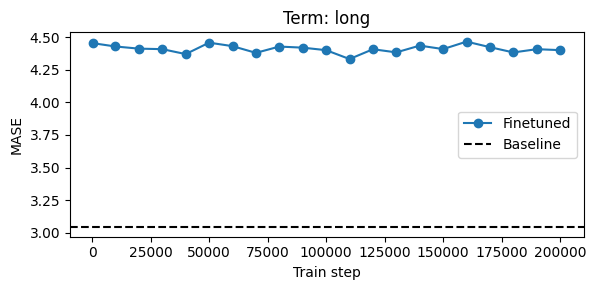

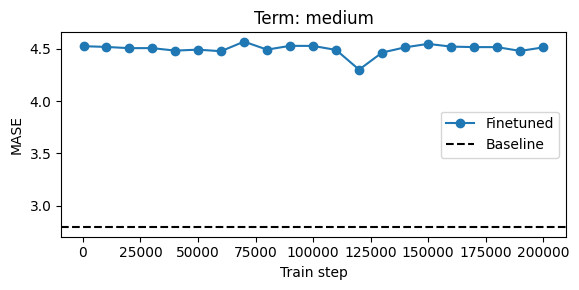

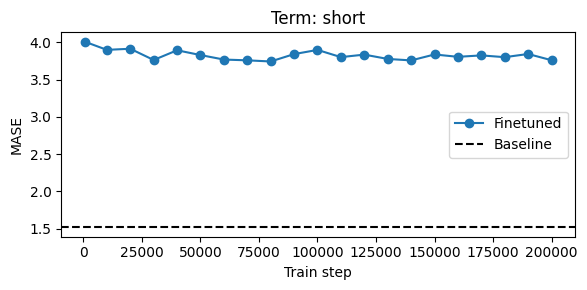

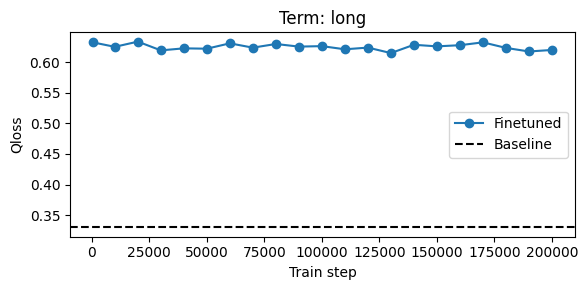

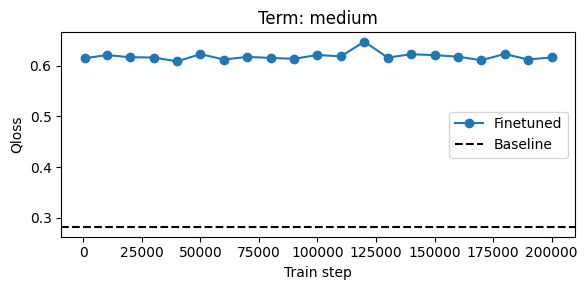

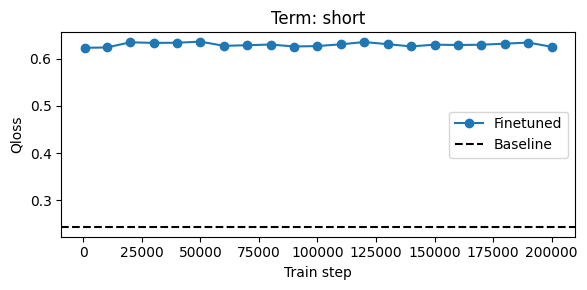

In [22]:
# Plot: One plot for each TERM value (short, medium, long)
plot_metric_vs_train_step(grouped_term, baseline_term, group_col="term", metric_cols=["MASE", "Qloss"], title_prefix="Term")

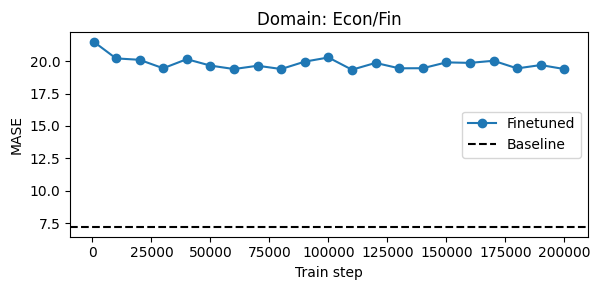

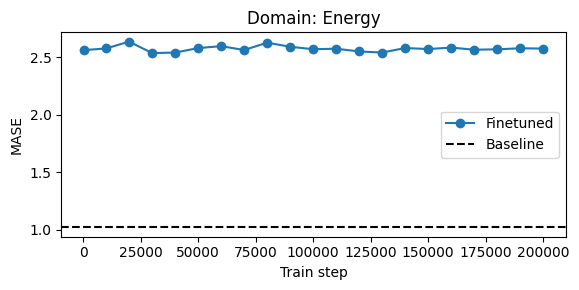

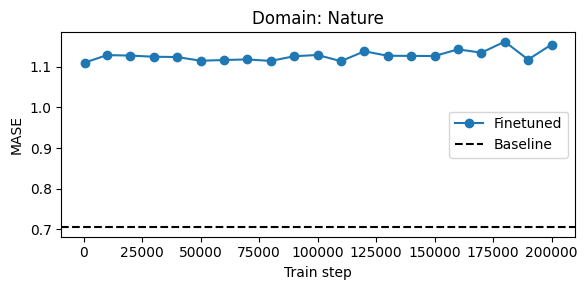

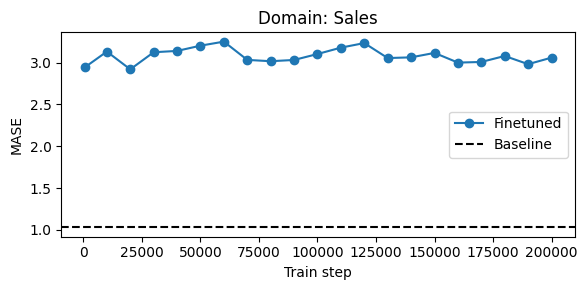

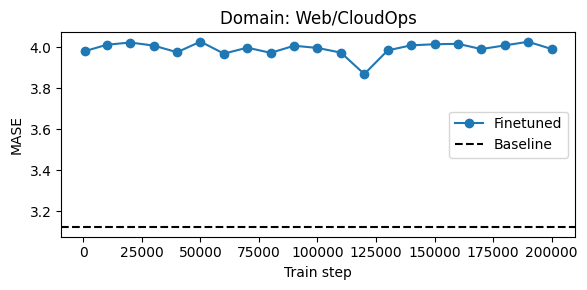

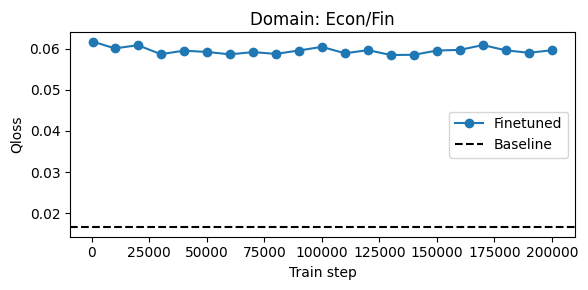

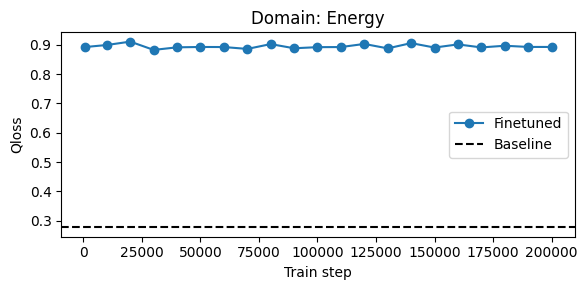

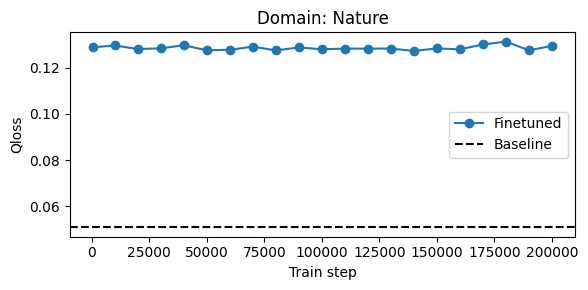

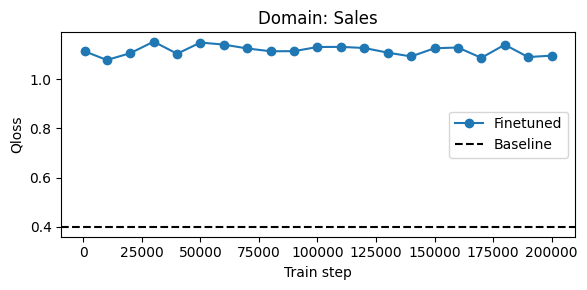

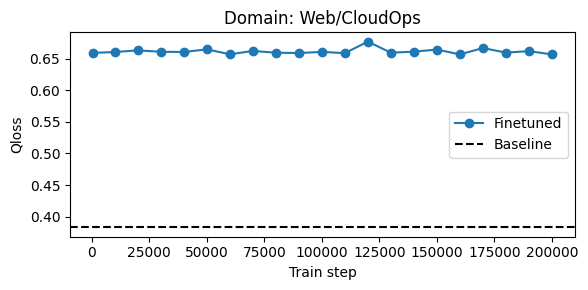

In [23]:
# Plot: One plot for each DOMAIN value (Econ/Fin, Weather, ecc.)
plot_metric_vs_train_step(grouped_domain, baseline_domain, group_col="domain", metric_cols=["MASE", "Qloss"], title_prefix="Domain")

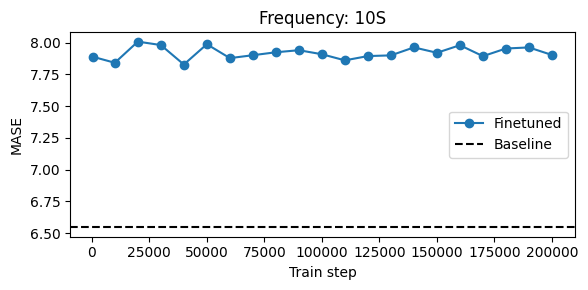

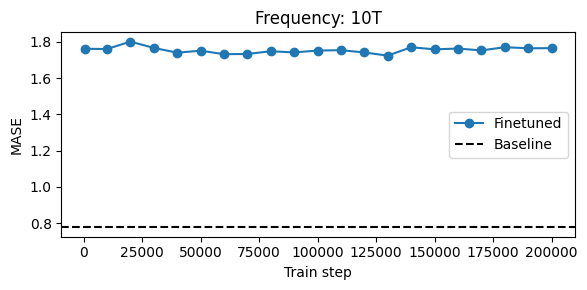

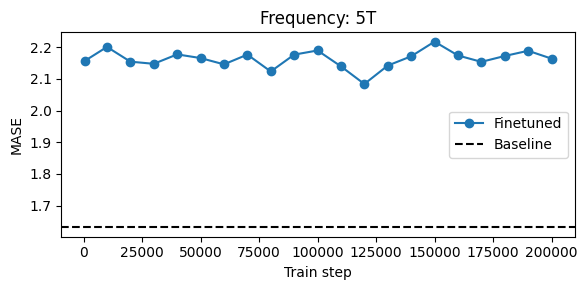

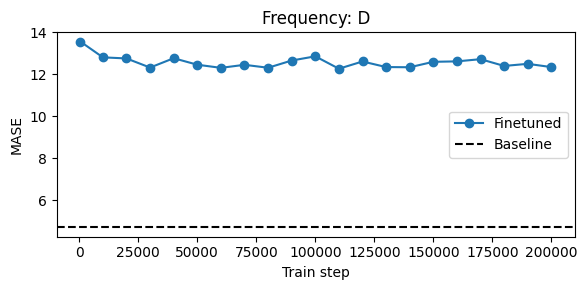

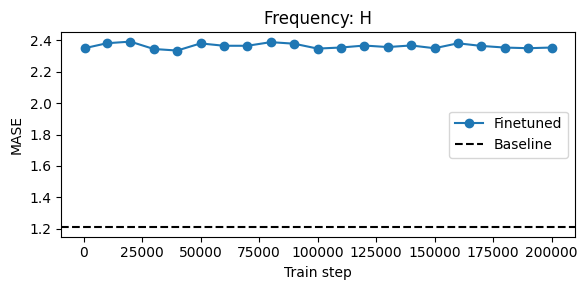

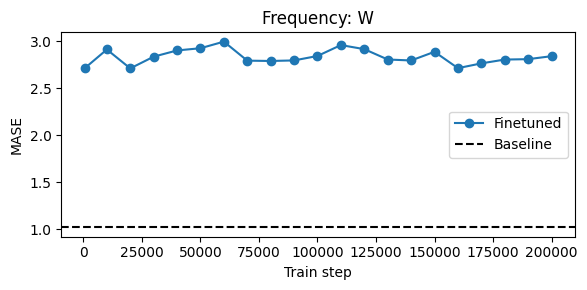

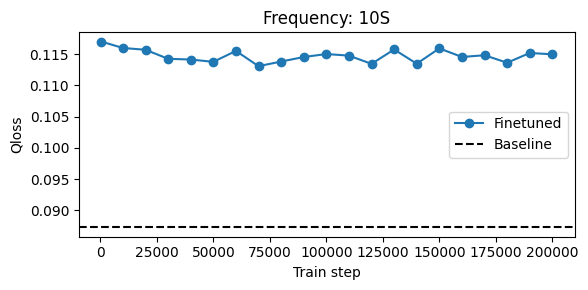

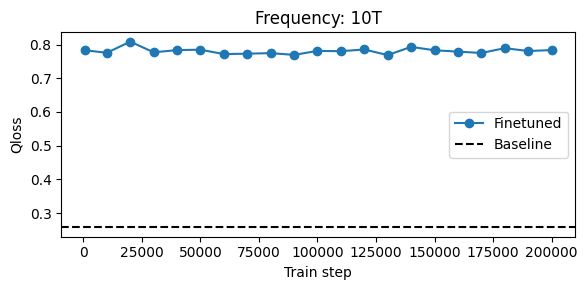

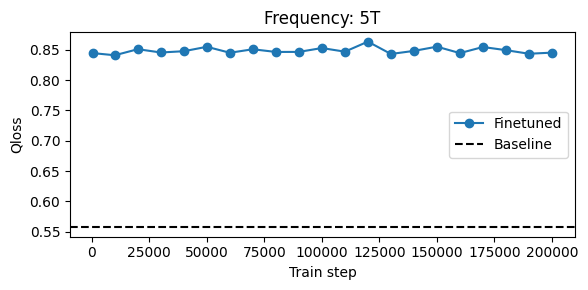

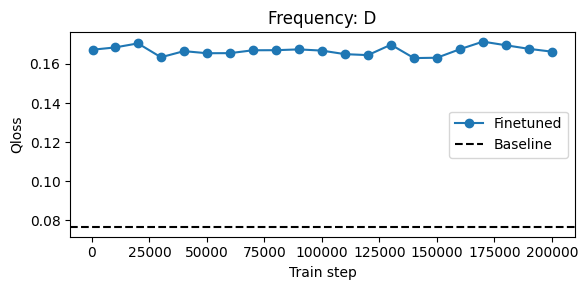

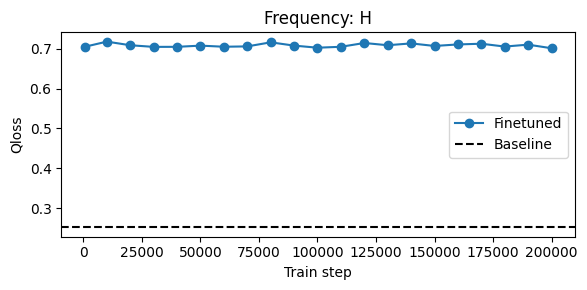

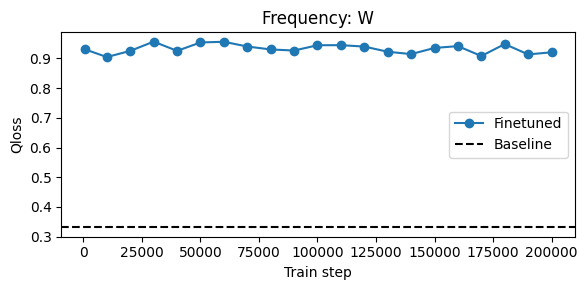

In [24]:
# Plot: One plot for each FREQ value
plot_metric_vs_train_step(grouped_freq, baseline_freq, group_col="freq", metric_cols=["MASE", "Qloss"], title_prefix="Frequency")

In [ ]:
grouped= df.groupby(['train step'], as_index=False).mean(numeric_only=True) # 'term', 'domain', 'freq'
grouped = grouped.sort_values(by=['train step'])[['train step', 'MASE', 'Qloss']]
print(grouped.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrr}
\toprule
train step & MASE & Qloss \\
\midrule
500 & 4.293 & 0.623 \\
10000 & 4.238 & 0.623 \\
20000 & 4.236 & 0.629 \\
30000 & 4.173 & 0.624 \\
40000 & 4.208 & 0.623 \\
50000 & 4.211 & 0.628 \\
60000 & 4.174 & 0.624 \\
70000 & 4.181 & 0.624 \\
80000 & 4.167 & 0.626 \\
90000 & 4.215 & 0.622 \\
100000 & 4.232 & 0.625 \\
110000 & 4.161 & 0.624 \\
120000 & 4.145 & 0.636 \\
130000 & 4.159 & 0.622 \\
140000 & 4.181 & 0.626 \\
150000 & 4.216 & 0.626 \\
160000 & 4.212 & 0.625 \\
170000 & 4.206 & 0.625 \\
180000 & 4.184 & 0.627 \\
190000 & 4.198 & 0.623 \\
200000 & 4.172 & 0.621 \\
\bottomrule
\end{tabular}



In [26]:
baseline_grouped = baseline_results.groupby(["model"], as_index=False).mean(numeric_only=True)
baseline_grouped = baseline_grouped[['model', 'MASE', 'Qloss']]
baseline_grouped

,model,MASE,Qloss
0,chronos_bolt_base,2.343453,0.279664
